# Predicting High-Traffic Recipes​
Supporting Smarter Homepage Curation with Data​

## Introduction
Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted inspiration so they decided to provide it, starting life as a search engine for recipes, helping people to find ways to use up the limited supplies they had at home.

At the moment, their team chooses the favorite recipe from a selection and displays that on the home page. It has been noticed that traffic to the rest of the website goes up by as much as 40% if a popular recipe is picked. But they don’t know how to decide if a recipe will be popular. More traffic means more subscriptions so this is really important to the company.

The task is to predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular ones.

# Data Validation
This data set has 947 rows, 8 columns. I have validated all variables and have made some changes after validation.
- **recipe:** Confirmed that values are unique and numeric. No cleaning was required.

- **servings:** Cleaned the column by extracting the numeric portion from mixed text entries ("4 as a snack") and converted the values to integers.

- **calories, carbohydrate, sugar, protein:** Verified that these columns are numeric and checked for null values. Filled the 52 missing values in the columns with their respective medians to retain valid numeric data. Inspected summary statistics (min, max, mean) to ensure values are within expected ranges. 

- **category:** Checked unique values to ensure they match the expected ten groups. Corrected inconsistent category labels by comparing unique values against the expected set and standardizing them using .replace().

- **high_traffic:** Verified that the entries are strings and checked the unique values. For modeling purposes, transformed this variable into a binary indicator (1 for "High", 0 for any other label).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [3]:
df = pd.read_csv("recipe_site_traffic_2212.csv")
df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [5]:
# Validate identifier uniqueness of recipe
df['recipe'].nunique()

947

In [6]:
# Validate values in 'servings'
df['servings'].unique()
df['servings'] = df['servings'].str.extract(r'(\d+)').astype(int)
df['servings'] = df['servings'].astype('int')

In [7]:
nutritional_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
df[nutritional_cols] = df[nutritional_cols].fillna(df[nutritional_cols].median())

In [8]:
# Outlier capping at 99th percentile for nutrition
for col in nutritional_cols:
    upper = df[col].quantile(0.99)
    df[col] = np.where(df[col] > upper, upper, df[col])

In [9]:
# Validate expected categories in 'category'
expected_categories = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 
                       'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']
set(df['category'].unique()) - set(expected_categories)
df['category'] = df['category'].replace({'Chicken Breast': 'Chicken'})
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

In [10]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [11]:
# Convert to a binary indicator
df['high_traffic'] = np.where(df['high_traffic'] == "High", 1, 0)

# Exploratory Analysis
## Distribution of Target Variable high_traffic
The dataset contains more high-traffic recipes (1) than non-high-traffic ones (0), indicating a moderately imbalanced classification problem. This impacts model evaluation as metrics like precision and recall will be more informative than accuracy alone.

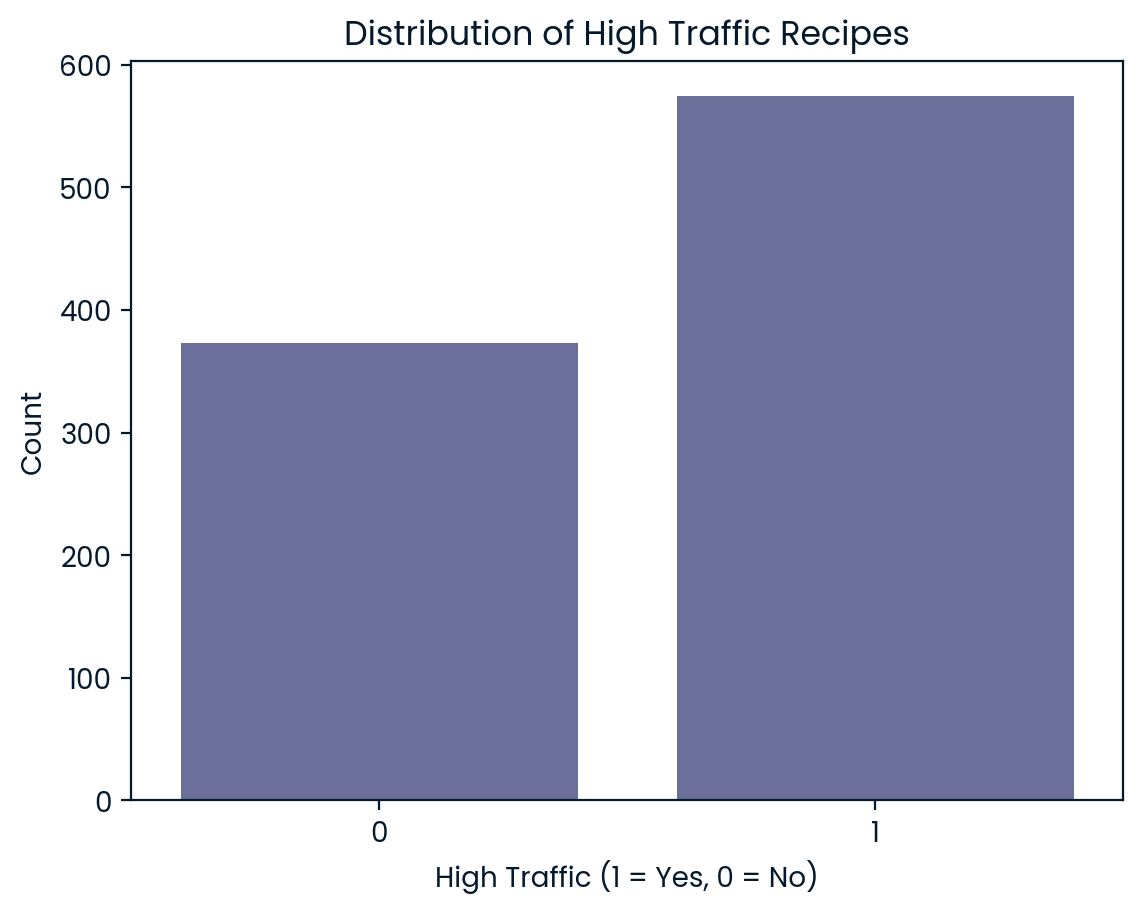

In [12]:
sns.countplot(data=df, x='high_traffic')
plt.title('Distribution of High Traffic Recipes')
plt.xlabel('High Traffic (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

## Distributions of Nutritional Features
All nutritional variables (calories, carbohydrate, sugar, protein) are heavily right-skewed, with most recipes clustered around lower values and a long tail of outliers. This skewness suggests we may need robust models that handle non-normality well (like decision trees), potential normalization or transformation for linear models.

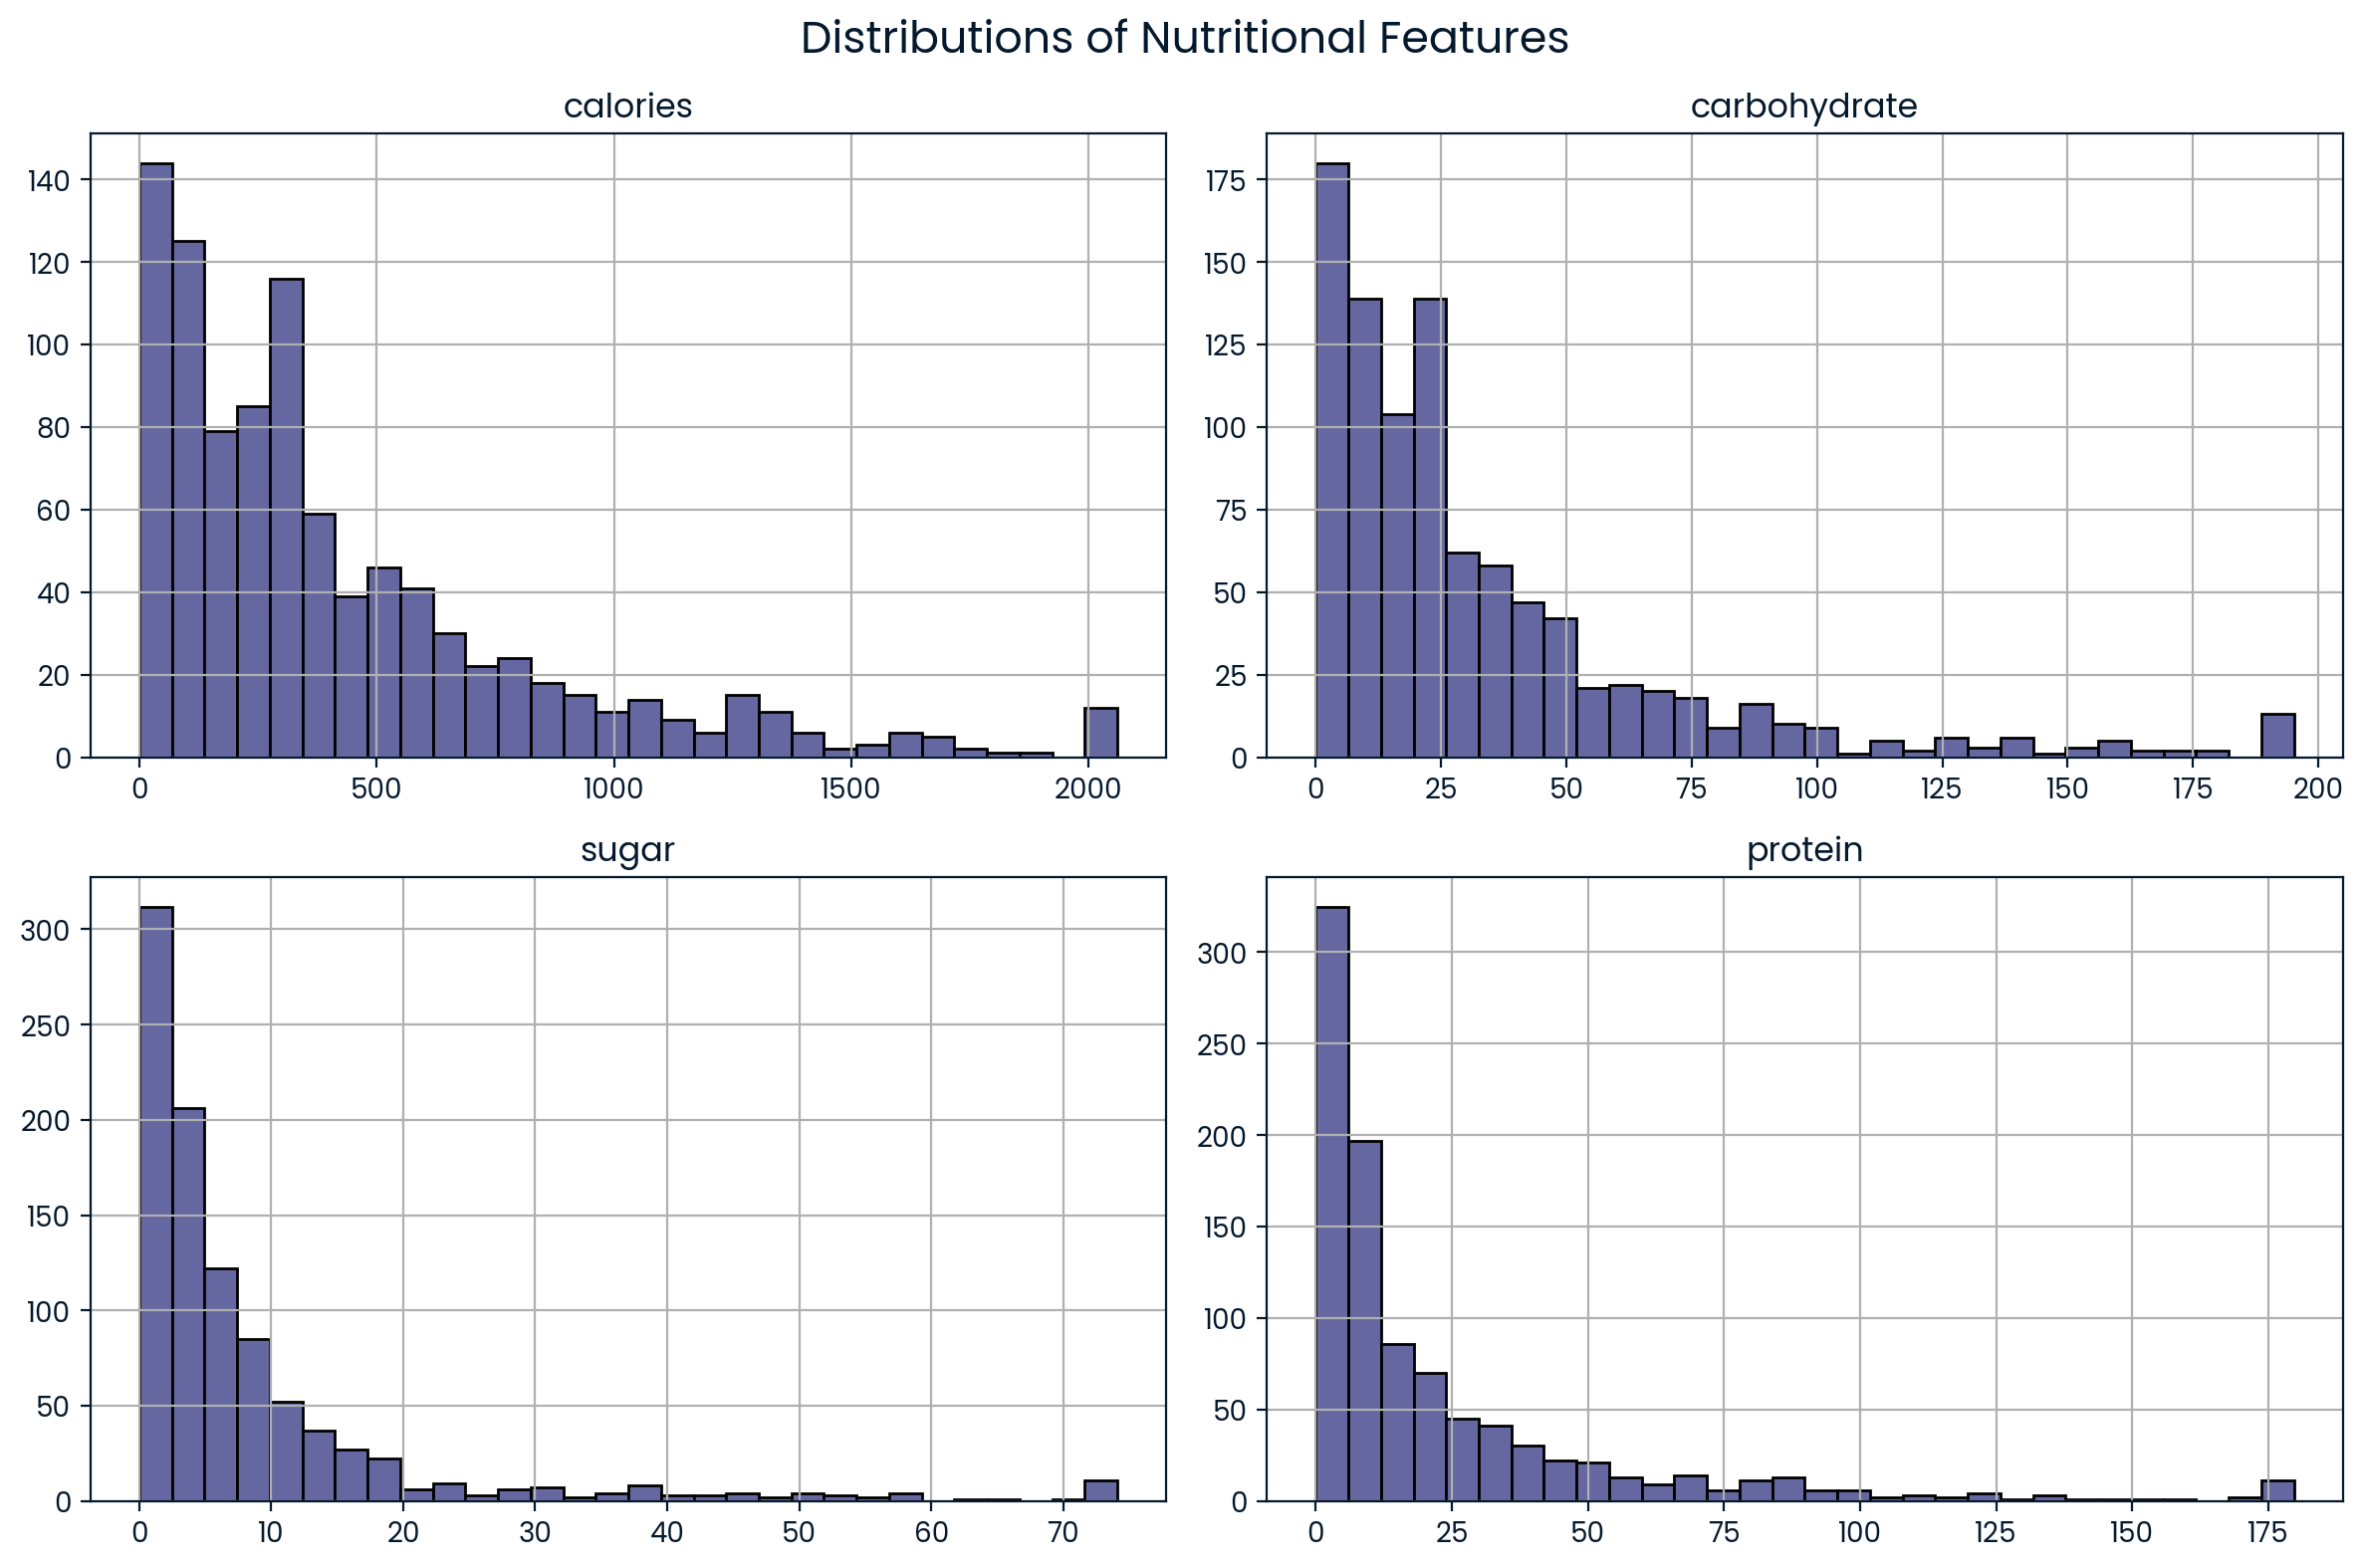

In [13]:
df[nutritional_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Nutritional Features", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# Log1p transform for linear models
for col in nutritional_cols:
    df[f'{col}_log'] = np.log1p(df[col])

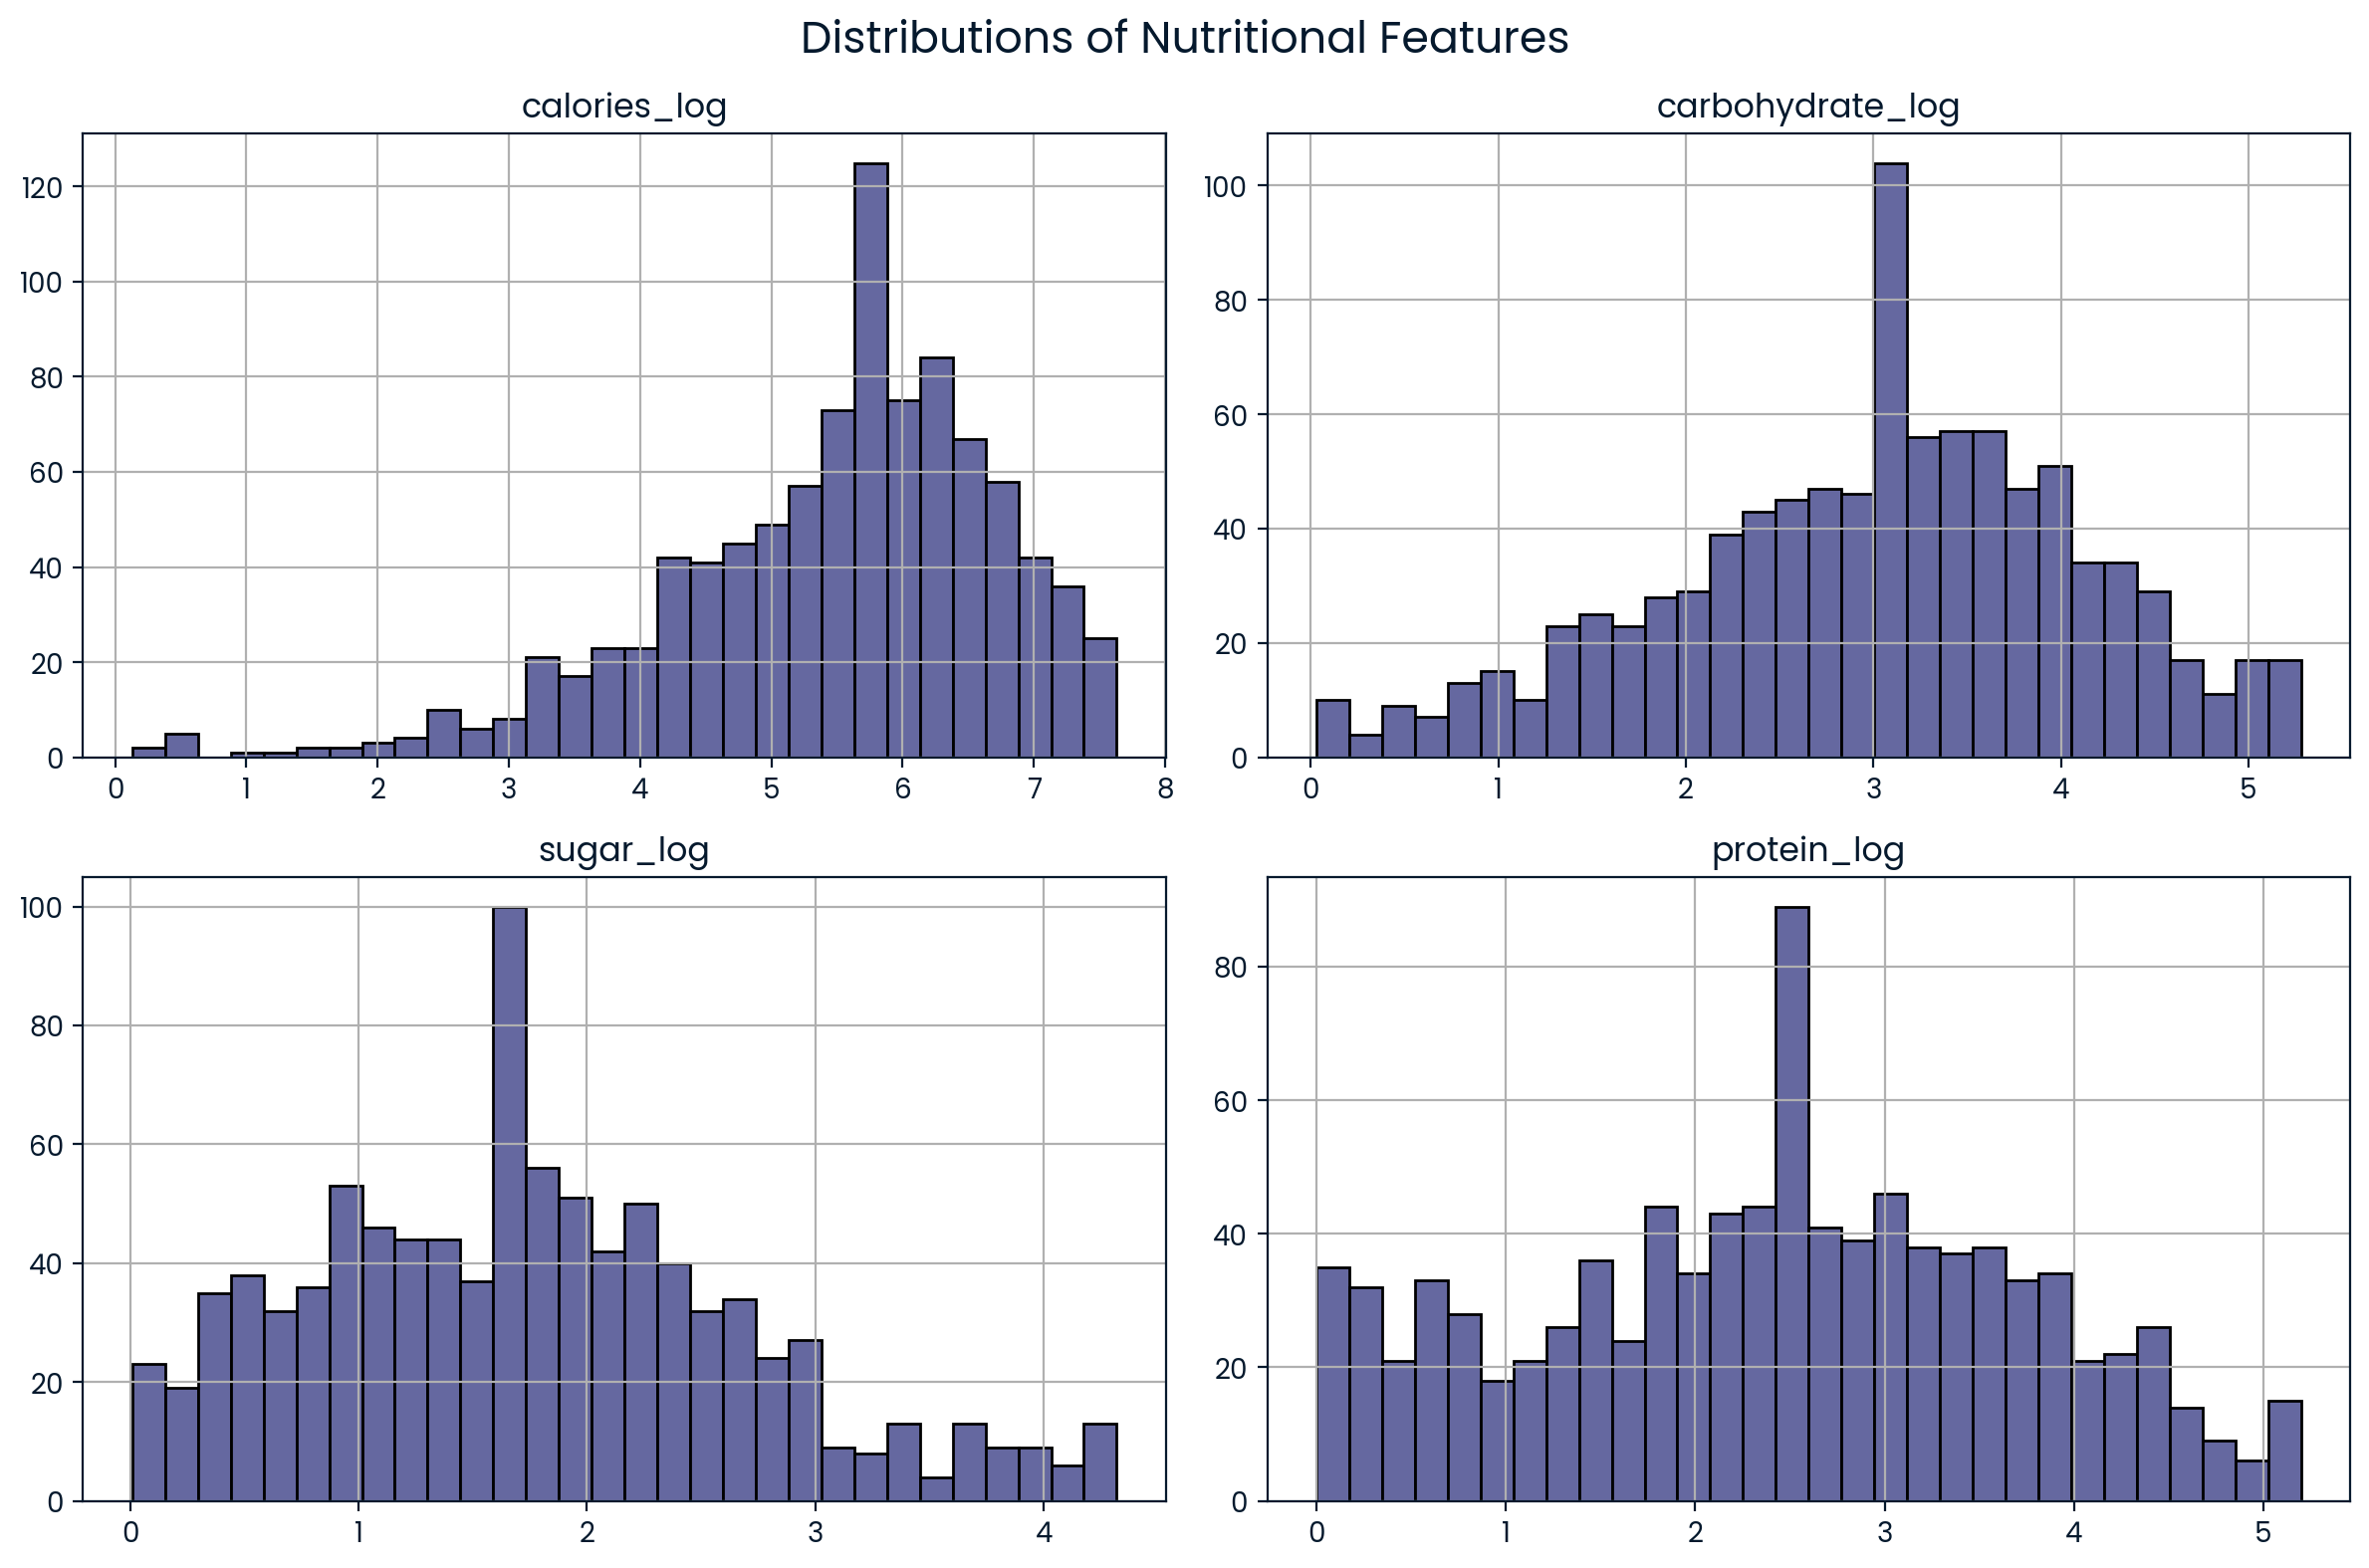

In [15]:
log_cols = ['calories_log', 'carbohydrate_log', 'sugar_log', 'protein_log']

df[log_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Nutritional Features", fontsize=16)
plt.tight_layout()
plt.show()

## Nutritional Features by Traffic Level
High-traffic recipes have slightly higher calories and carbs, as well as lower sugar numbers. Protein shows weak differences. All nutrition features should be included, but we shouldn't rely on them alone.

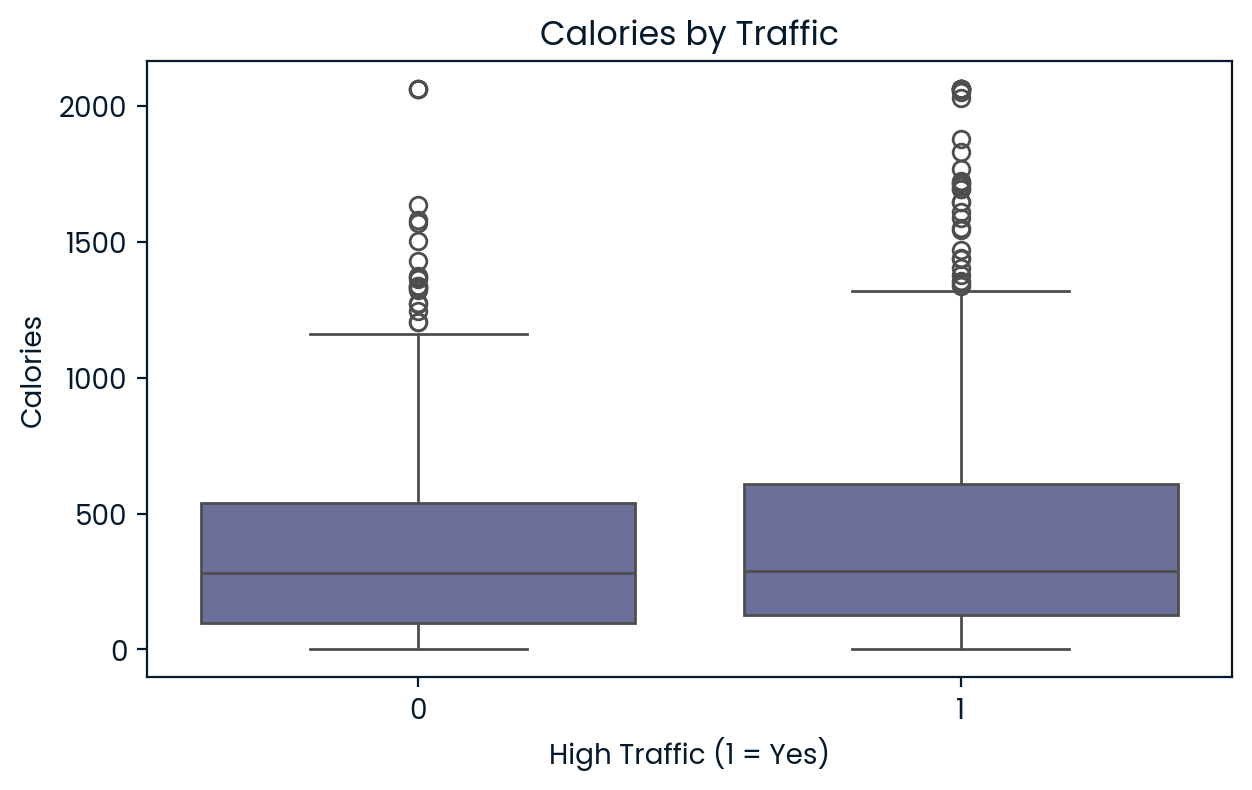

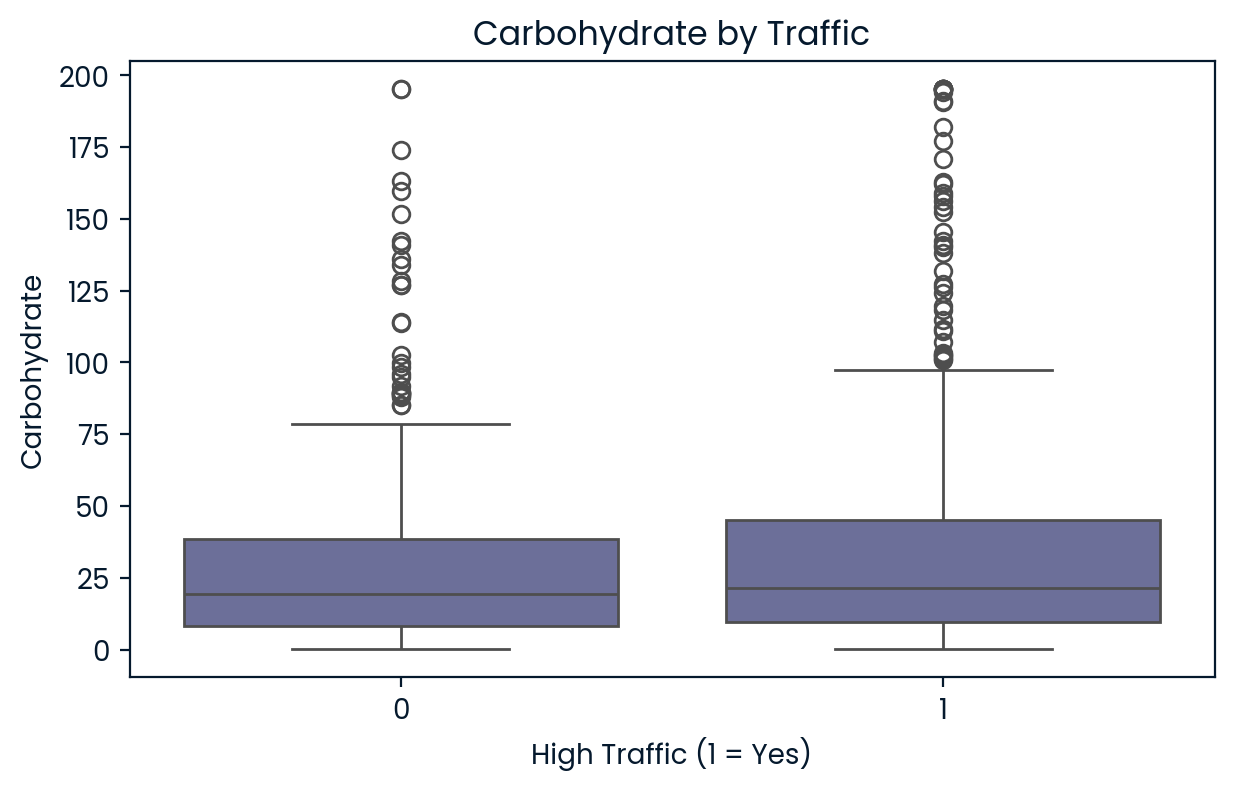

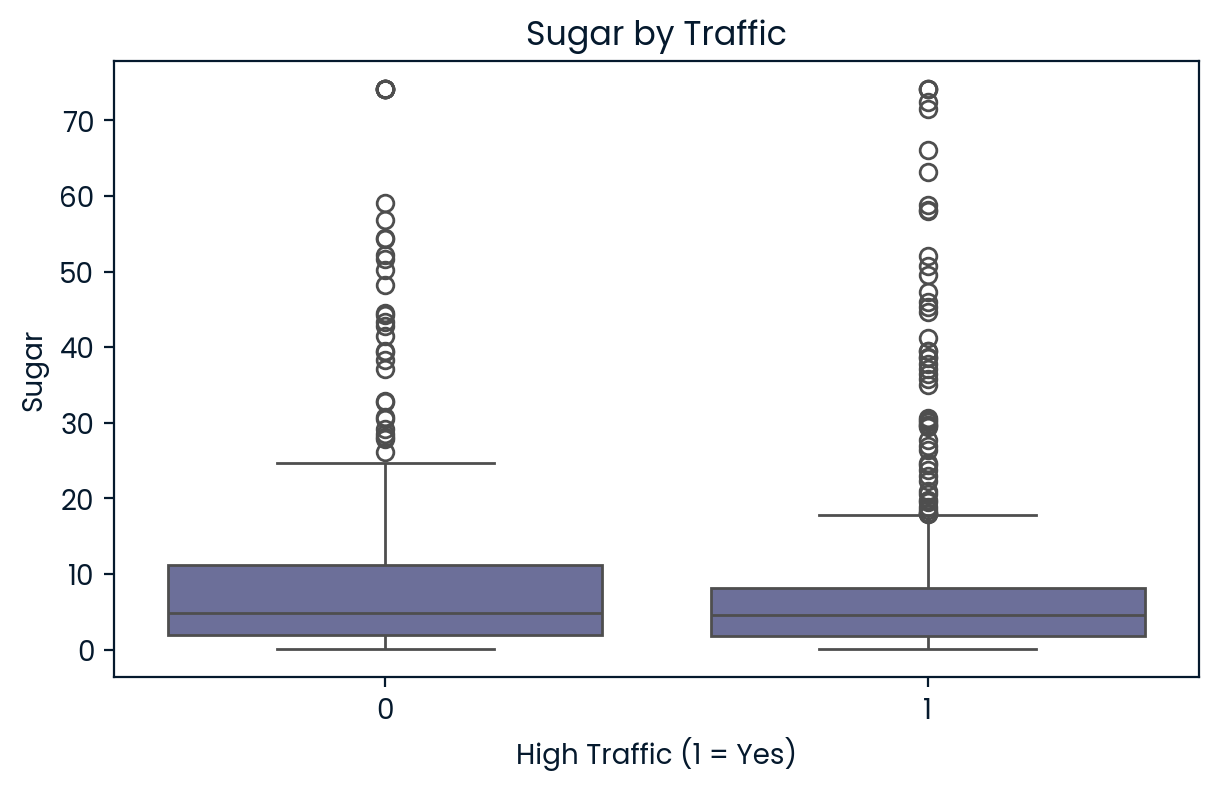

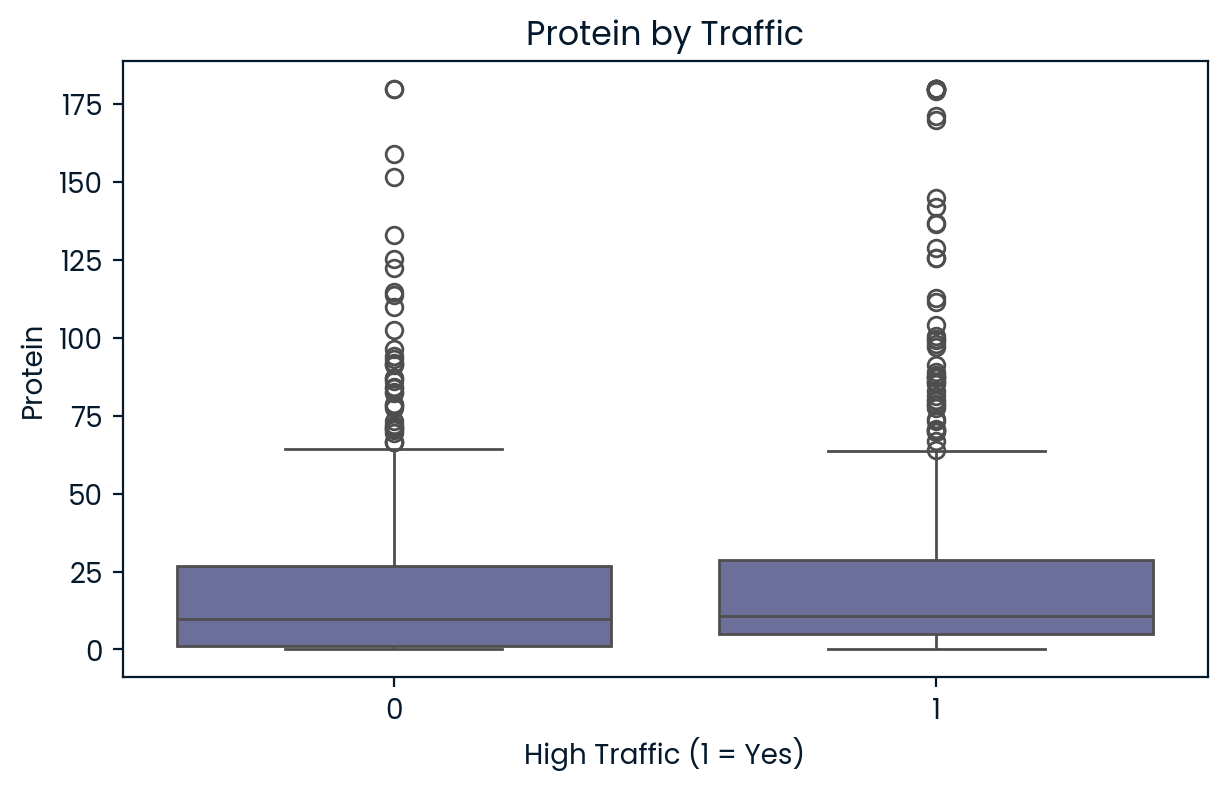

In [16]:
for col in nutritional_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='high_traffic', y=col)
    plt.title(f'{col.title()} by Traffic')
    plt.xlabel('High Traffic (1 = Yes)')
    plt.ylabel(col.title())
    plt.show()

## Servings by Traffic Level
Shows weak differences, should be included, but we shouldn't rely on it alone.

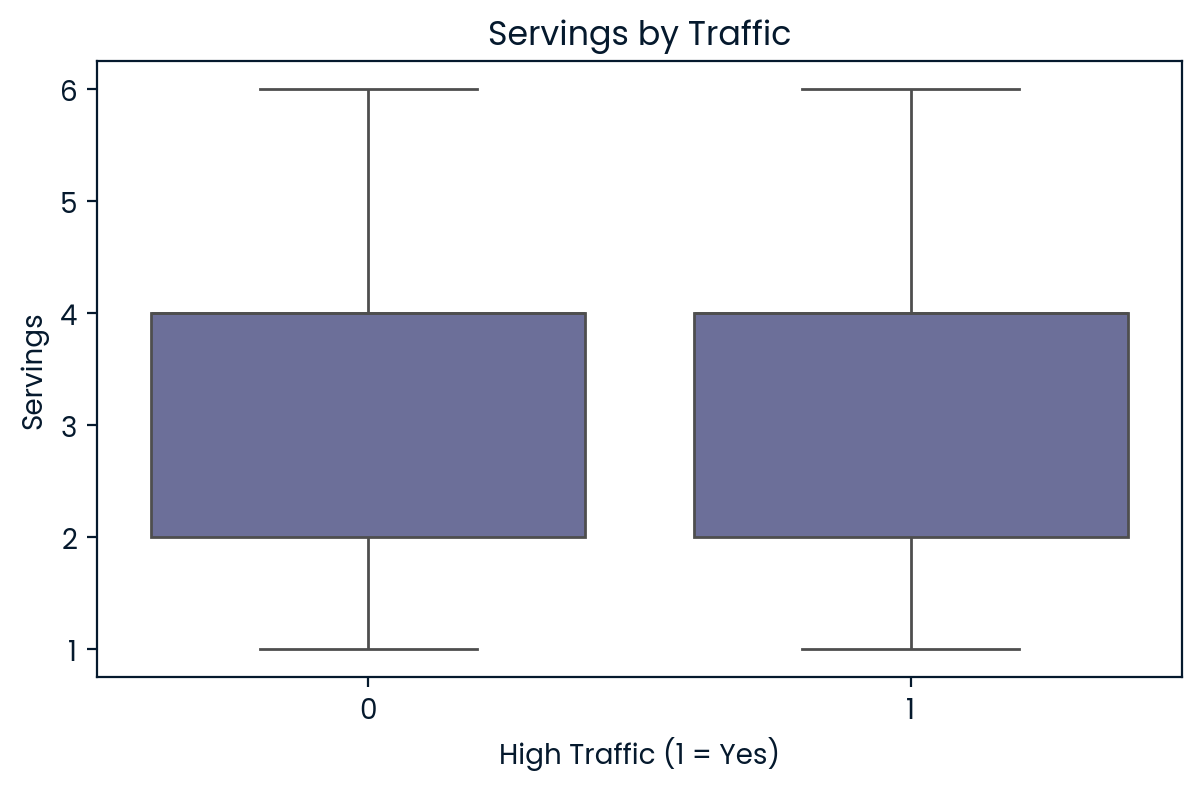

In [17]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=df, x='high_traffic', y='servings')
plt.title('Servings by Traffic')
plt.xlabel('High Traffic (1 = Yes)')
plt.ylabel('Servings')
plt.show()

## Correlation Matrix 
All nutrition‑traffic correlations are weak (|r|<0.2). Non‑linear models or richer features likely needed.

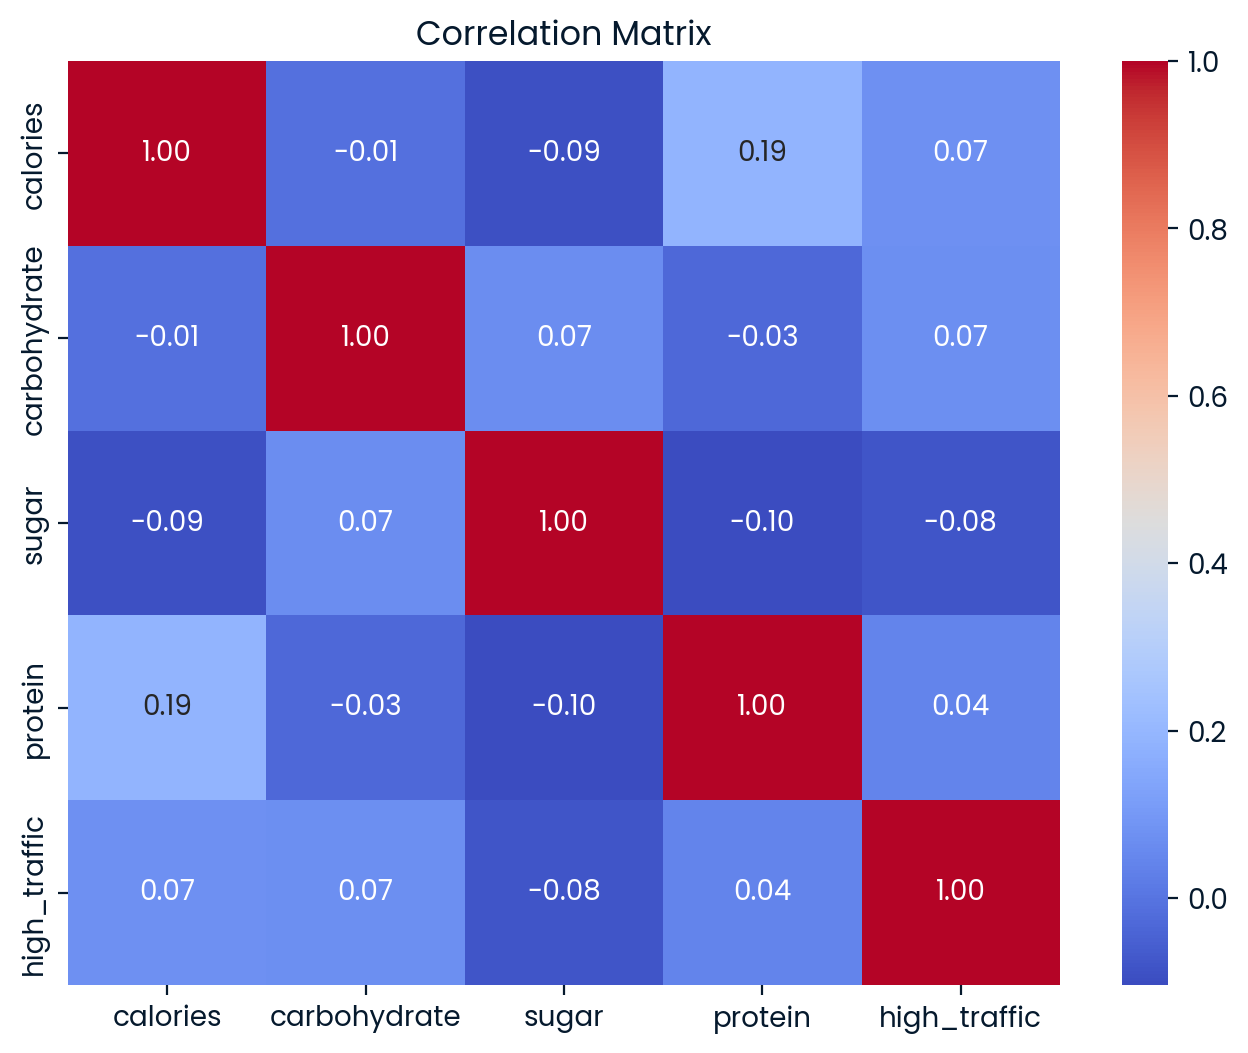

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[nutritional_cols + ['high_traffic']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Category Analysis
Some categories have >70% high-traffic. One of the strongest predictors, should be one-hot encoded.

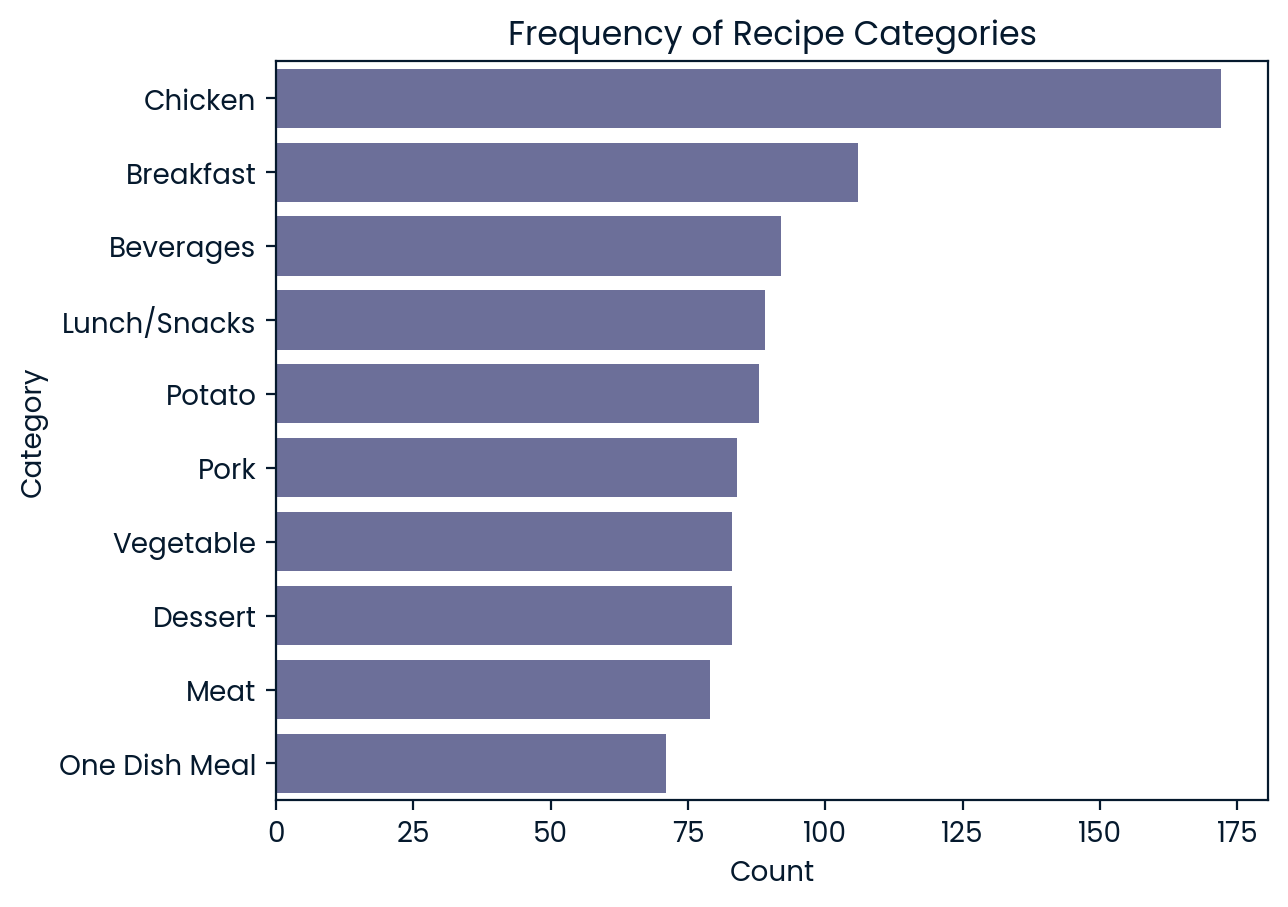

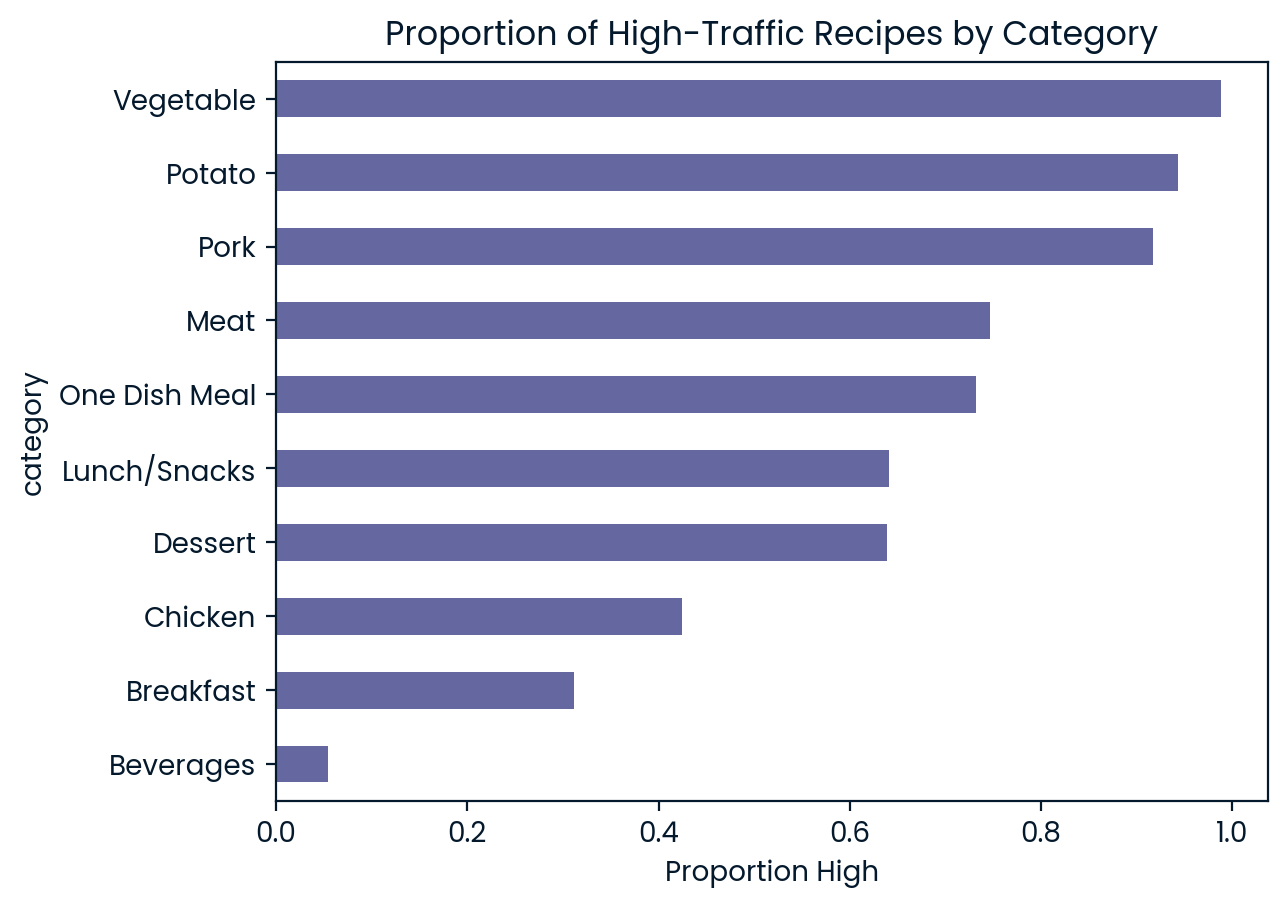

In [19]:
sns.countplot(data=df, y='category', order=df['category'].value_counts().index)
plt.title('Frequency of Recipe Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

df.groupby('category')['high_traffic'].mean().sort_values().plot(kind='barh')
plt.title("Proportion of High-Traffic Recipes by Category")
plt.xlabel("Proportion High")
plt.show()

# Modeling
This is a binary classification problem where the goal is to predict whether a recipe will be high-traffic (1) or not (0).

In [20]:
# Feature Preparation
df_model = pd.get_dummies(df, columns=['category'], drop_first=True)

features = log_cols + ['servings'] + [c for c in df_model.columns if 'category_' in c]
X = df_model[features]
y = df_model['high_traffic']

Logistic regression is interpretable, fast, useful for setting probability thresholds (which the product team cares about). Decision Trees can capture non-linear relationships and handle categorical splits effectively.

In [21]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression as a baseline model
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Decision Tree as a comparison model
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

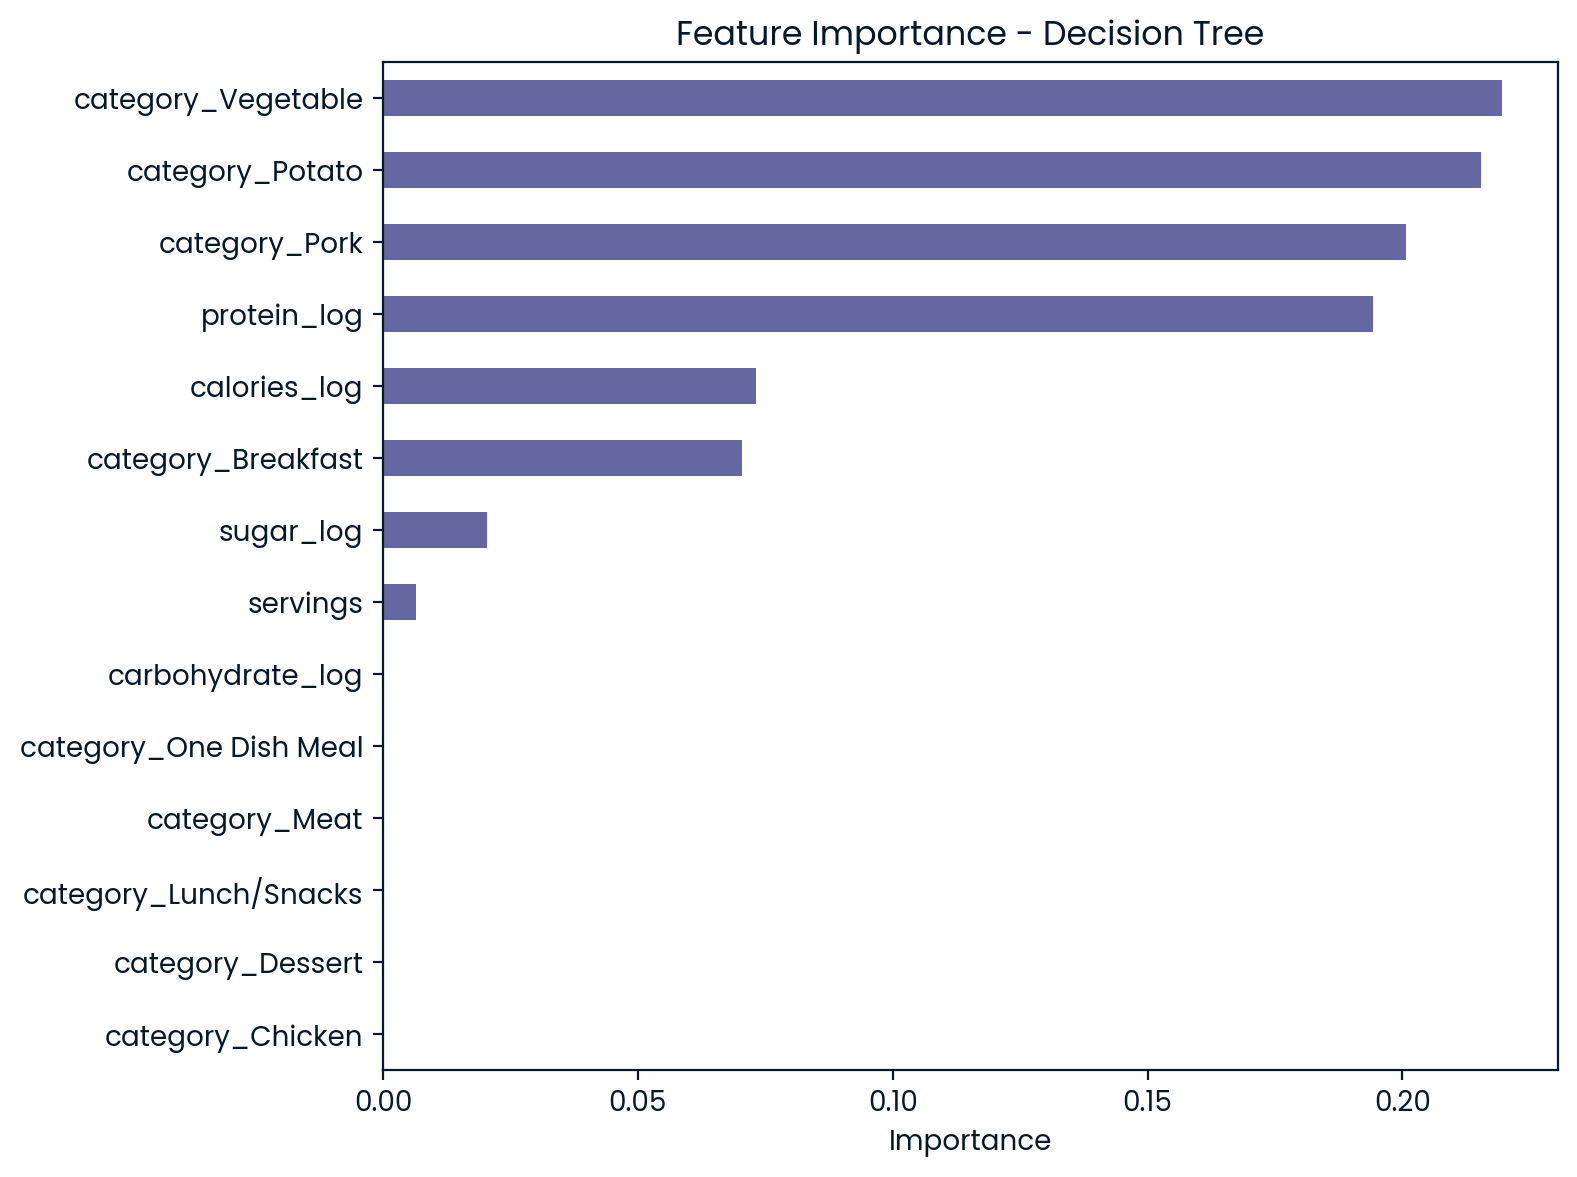

In [22]:
feature_importances = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
feature_importances.plot(kind='barh')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance')
plt.tight_layout()
plt.show() 

# Evaluation
Logistic regression is more balanced. The Decision Tree hits a 98.6% precision, almost never recommending a bad recipe, but misses more good ones. That’s a tradeoff we’ll return to in our business recommendation.

In [24]:
def evaluate(model_name, y_true, y_pred):
    print(f"--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate("Logistic Regression", y_test, y_pred_lr)
evaluate("Decision Tree", y_test, y_pred_dt)

--- Logistic Regression ---
Accuracy : 0.7263157894736842
Precision: 0.8518518518518519
Recall   : 0.6647398843930635
              precision    recall  f1-score   support

           0       0.61      0.82      0.70       112
           1       0.85      0.66      0.75       173

    accuracy                           0.73       285
   macro avg       0.73      0.74      0.72       285
weighted avg       0.76      0.73      0.73       285

--- Decision Tree ---
Accuracy : 0.6385964912280702
Precision: 0.9861111111111112
Recall   : 0.41040462427745666
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       112
           1       0.99      0.41      0.58       173

    accuracy                           0.64       285
   macro avg       0.75      0.70      0.63       285
weighted avg       0.80      0.64      0.62       285



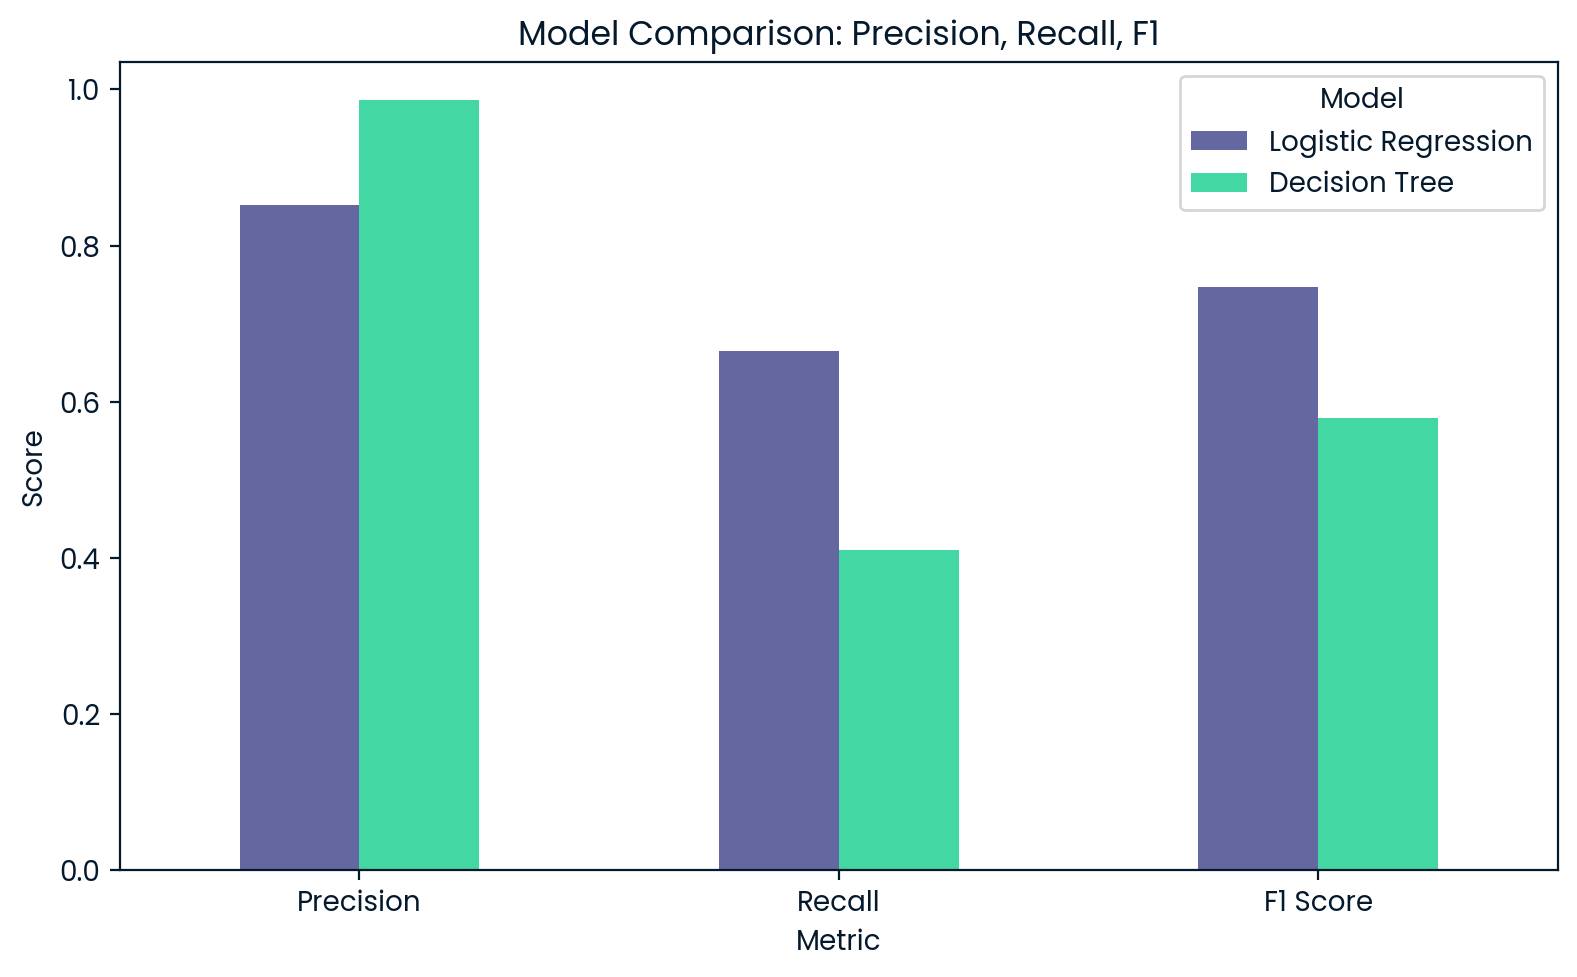

In [25]:
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Logistic Regression': [
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ],
    'Decision Tree': [
        precision_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_dt)
    ]
}).set_index('Metric')

metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title('Model Comparison: Precision, Recall, F1')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Business Metric
Metric: Precision@High

Of all recipes we predict to be high-traffic, what percent actually are?

Logistic Regression provides a strong balance between catching enough high-traffic recipes (recall) and maintaining high precision. Decision Tree sacrifices recall but nearly eliminates false positives. At 98.6% precision, it very rarely misidentifies a recipe as high-traffic when it’s not. Since the business prioritizes avoiding poor homepage picks, the Decision Tree model is the stronger fit, despite its lower recall. It offers the high confidence that the product team needs.

# Final Recommendations

1. **Deploy the Decision Tree for Homepage Recommendations**
The tree model delivers nearly perfect precision, which meets and exceeds the product team's 80% target. Its prediction style fits the homepage use case, where wrong picks are more damaging than missed picks.

2. **Establish Weekly Monitoring**
Set up a simple dashboard to track model precision over time. If precision drops below 75%, retraining should be triggered. This buffer ensures we maintain reliability.

3. **Expand the Feature Set to Improve Model Depth**
Current features are relatively simple, so to improve both precision and recall over time, I recommend collecting and incorporating: User Ratings, Prep Time, Seasonality Tags, Ingredient types (like vegan, gluten-free). 

4. **Improve Recall Later with More Advanced Models**
For early deployment we’ve prioritized being right over being complete. However, once precision is stable and trusted, we can work to increase recall (catch more high-performing recipes) using Random Forest, threshold tuning etc. These methods could help feature more high-traffic recipes without substantially increasing the risk of featuring unpopular ones.